In [25]:
import numpy as np
from math import floor, pi, sqrt, asin
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def apply_phase_oracle(qc: QuantumCircuit, qr: QuantumRegister, target: int):
    n = len(qr)
    bitstr = format(target, f"0{n}b")[::-1]
    zero_positions = [i for i, b in enumerate(bitstr) if b == "0"]

    # Flip qubits where target has 0 so |target> -> |1...1>
    for i in zero_positions:
        qc.x(qr[i])

    # Apply phase flip to |1...1> (i.e. apply -1 to |target>)
    if n == 1:
        # Z: |1> -> -|1>
        qc.z(qr[0])
    elif n == 2:
        # CZ: |11> -> -|11>
        qc.cz(qr[0], qr[1])
    else:
        controls = [qr[i] for i in range(n - 1)]
        target_qubit = qr[n - 1]
        # H: map Z <-> X
        qc.h(target_qubit)
        # MCX targets |1...1>
        qc.mcx(controls, target_qubit)
        qc.h(target_qubit)

    # Undo flips to restore original basis (keeps global phase on |target>)
    for i in zero_positions:
        qc.x(qr[i])


def diffusion_operator(qc: QuantumCircuit, qr: QuantumRegister):
    n = len(qr)
    # H on all qubits: build |s> basis and implement H^{\otimes n}
    # Note: |s> = H^{\otimes n}|0...0> = (1/sqrt(N)) sum_x |x>
    qc.h(qr)

    # X on all qubits so that |0...0> <-> |1...1>
    # We want to implement a phase flip on |0...0>. It's easier to flip the phase
    # of |1...1>, so we map |0...0> -> |1...1> using X^{\otimes n}.
    qc.x(qr)

    # Multi-controlled phase on |1...1>
    # For n=1 and n=2 we can use simple Z and CZ gates.
    # For n>2 we implement a multi-controlled Z using a multi-controlled X
    # surrounded by H on the target (H X H = Z).
    if n == 1:
        # Single qubit: Z flips phase of |1> -> -|1>
        qc.z(qr[0])
    elif n == 2:
        # Two qubits: CZ flips phase of |11> -> -|11>
        qc.cz(qr[0], qr[1])
    else:
        # For n > 2: implement multi-controlled Z on |1...1>.
        # Let controls = first n-1 qubits, target = last qubit.
        # Use H(target); MCX(controls -> target); H(target) to realize multi-controlled Z.
        controls = [qr[i] for i in range(n - 1)]
        target_qubit = qr[n - 1]
        # H: map Z <-> X on the target qubit so MCX acts as a controlled-Z
        qc.h(target_qubit)
        # mcx flips the target when all controls are |1>, i.e. applies X conditioned on controls.
        # With the H's it becomes a phase flip on the joint state |1...1>.
        qc.mcx(controls, target_qubit)
        qc.h(target_qubit)
    # Undo the X and H: complete inversion
    qc.x(qr)
    qc.h(qr)

def build_grover_circuit(n: int, target: int, iterations: int = None, measure: bool = True):
    qr = QuantumRegister(n, "q")
    cr = ClassicalRegister(n, "c")
    qc = QuantumCircuit(qr, cr)
    # H on all qubits: |0...0> -> |s> = (1/√N) Σ_x |x>
    qc.h(qr)
    N = 2 ** n
    if iterations is None:
        # r ≈ ⌊(π/4)√N⌋ (number of Grover iterations)
        r = max(1, int(floor((pi / 4) * sqrt(N))))
    else:
        r = int(iterations)
    # Apply r iterations: oracle O then diffusion D -> (D O)^r |s>
    for _ in range(r):
        apply_phase_oracle(qc, qr, target)
        diffusion_operator(qc, qr)
    if measure:
        # Measure register to classical bits: |x> -> c = x
        qc.measure(qr, cr)
    return qc, r

def statevector_counts(qc: QuantumCircuit, shots: int = 1024):
    n = qc.num_qubits
    sv = Statevector.from_instruction(qc)
    probs = np.abs(sv.data) ** 2
    probs = probs / np.sum(probs)
    outcomes = np.arange(len(probs))
    samples = np.random.choice(outcomes, size=shots, p=probs)
    counts = {}
    for s in samples:
        bitstr = format(int(s), f"0{n}b")
        counts[bitstr] = counts.get(bitstr, 0) + 1
    return counts

def run_and_plot(qc: QuantumCircuit, shots: int = 1024):
    qc_display = qc.copy()
    ops = qc_display.count_ops()
    has_measure = ops.get("measure", 0) > 0
    if not has_measure and qc_display.num_qubits > 0 and qc_display.num_clbits > 0:
        qr = qc_display.qregs[0]
        cr = qc_display.cregs[0]
        qc_display.measure(qr, cr)

    fig = qc_display.draw(output="mpl", idle_wires=False)
    plt.show(fig)
    counts = statevector_counts(qc, shots=shots)
    print("Counts:", counts)
    plot_histogram(counts)
    plt.show()
    most_likely = max(counts, key=counts.get)
    print(f"Most likely measured state: {most_likely}")
    return counts


def theoretical_probability(N: int, r: int) -> float:
    theta = asin(1.0 / sqrt(N))
    return np.sin((2 * r + 1) * theta) ** 2


In [26]:
# Activity 1
def run_grover_2qubit(target_binary: str = "10", shots: int = 1024):
    # Convert the provided binary string to an integer for the oracle.
    target_int = int(target_binary, 2)
    # Fixed for this activity: 2 qubits and 1 iteration.
    n = 2
    iterations = 1
    qc, r_used = build_grover_circuit(n, target_int, iterations, measure=False)
    print(f"Running Grover (n={n}) searching for |{target_binary}> (int {target_int}), iterations={r_used}")
    counts = run_and_plot(qc, shots=shots)
    return counts

if __name__ == "__main__":
    run_grover_2qubit("10", shots=1024)


Running Grover (n=2) searching for |10> (int 2), iterations=1
Counts: {'10': 1024}
Most likely measured state: 10


r= 1  empirical=0.7793 (798/1024)  theoretical=0.7812
r= 2  empirical=0.9453 (968/1024)  theoretical=0.9453
r= 3  empirical=0.3291 (337/1024)  theoretical=0.3301
r= 4  empirical=0.0068 (7/1024)  theoretical=0.0122
r= 5  empirical=0.5518 (565/1024)  theoretical=0.5480
r= 6  empirical=1.0000 (1024/1024)  theoretical=0.9998
r= 7  empirical=0.5605 (574/1024)  theoretical=0.5770
r= 8  empirical=0.0234 (24/1024)  theoretical=0.0195
r= 9  empirical=0.2783 (285/1024)  theoretical=0.3029
r=10  empirical=0.9248 (947/1024)  theoretical=0.9313
r=11  empirical=0.7832 (802/1024)  theoretical=0.8049
r=12  empirical=0.1406 (144/1024)  theoretical=0.1450
r=13  empirical=0.1016 (104/1024)  theoretical=0.1063
r=14  empirical=0.7305 (748/1024)  theoretical=0.7566
r=15  empirical=0.9541 (977/1024)  theoretical=0.9578
r=16  empirical=0.3574 (366/1024)  theoretical=0.3578
r=17  empirical=0.0117 (12/1024)  theoretical=0.0066
r=18  empirical=0.5264 (539/1024)  theoretical=0.5188
r=19  empirical=0.9980 (1022/10

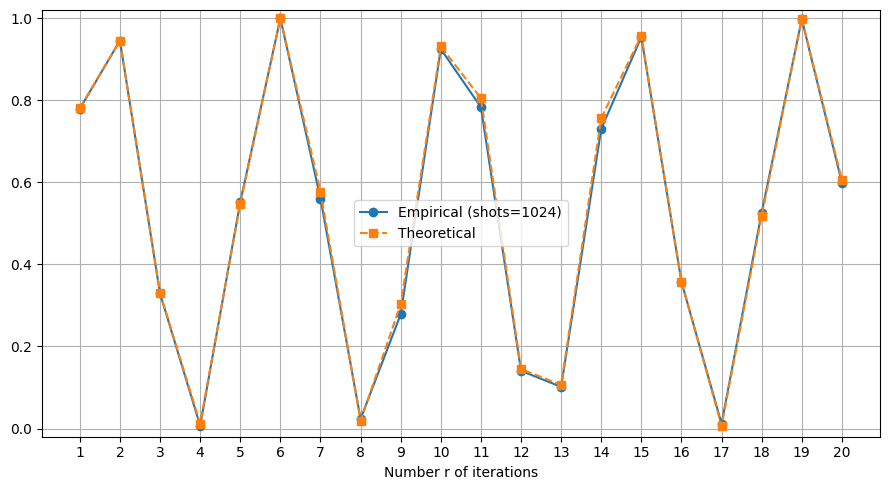

In [28]:
# Activity 2
def run_grover_3qubit_scan(target_binary: str = "101", r_max: int = 20, shots: int = 1024):
    # Convert the provided binary string to an integer for the oracle.
    target_int = int(target_binary, 2)
    # Fixed for this activity: 3 qubit.
    N = 2 ** 3

    rs = list(range(1, r_max + 1))
    empirical_probs = []
    theoretical_probs = []

    for r in rs:
        qc, _ = build_grover_circuit(3, target_int, iterations=r, measure=False)
        counts = statevector_counts(qc, shots=shots)
        success_counts = counts.get(target_binary, 0)
        p_emp = success_counts / shots
        p_theo = theoretical_probability(N, r)
        empirical_probs.append(p_emp)
        theoretical_probs.append(p_theo)
        print(f"r={r:2d}  empirical={p_emp:.4f} ({success_counts}/{shots})  theoretical={p_theo:.4f}")

    plt.figure(figsize=(9, 5))
    plt.plot(rs, empirical_probs, 'o-', label='Empirical (shots={})'.format(shots))
    plt.plot(rs, theoretical_probs, 's--', label='Theoretical')
    plt.xlabel('Success probability')
    plt.xlabel('Number r of iterations')
    plt.xticks(rs)
    plt.ylim(-0.02, 1.02)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_grover_3qubit_scan(target_binary="101", r_max=20, shots=1024)
